In [ ]:
from google.colab import auth
import os
auth.authenticate_user()
from google.cloud import bigquery
!gcloud config set project hmrecommendation


Updated property [core/project].


In [ ]:
project_id = 'hmrecommendation'
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id
client = bigquery.Client(project=project_id)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
df_val_cus = client.query('''
  SELECT 
    *
  FROM `hmrecommendation.hm_dataset.valuable_customer`''').to_dataframe()

In [ ]:
# from google.colab import files
# df_val_cus.to_csv('valuable_customer.csv') 
# df_join.to_csv('trans_cust_article_join.csv') 
# files.download('valuable_customer.csv')
# files.download('trans_cust_article_join.csv')

In [ ]:
df_val_cus.shape

(45693, 7)

In [ ]:
df_val_cus.columns

Index(['int64_field_0', 'customer_id', 'Frequency', 'Monetary',
       'frequency_score', 'monetary_score', 'valuable'],
      dtype='object')

In [ ]:
df_val_cus['valuable'].value_counts()

0    28883
1    16810
Name: valuable, dtype: int64

In [ ]:
df_val_cus.head()

,int64_field_0,customer_id,Frequency,Monetary,frequency_score,monetary_score,valuable
0,17910,64a228eb429b8e1d65ecd8c1e4ac35c758776c1d3e88b8...,1,0.008898,2,1,0
1,26709,9592fb94a5e858ef79801e06b12e388bb25019a02f7ae7...,1,0.005339,3,1,0
2,3167,11fbc75105b6ea614a573904e7593dd2151bcf4fbc4835...,1,0.010678,1,1,0
3,24278,884d47a045c024745ecf982ddbde9c0e2e701eb8072c9e...,1,0.010678,3,1,0
4,45162,fd4f5d5aa333c67856daab1c53e3b2f6616d6768c01904...,1,0.010678,5,1,0


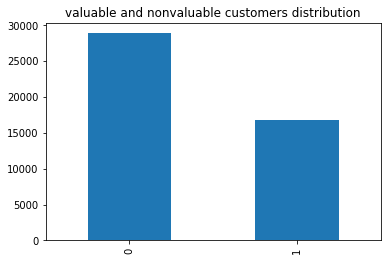

In [ ]:
df_val_cus['valuable'].value_counts().plot(kind='bar',title='valuable and nonvaluable customers distribution')

plot

valuable customers/ non-valuable customers ( valuable_cust['monetary_score']>=3) & (valuable_cust['frequency_score']>=3)

In [ ]:
##df_val_join0['age'].value_counts().plot(kind='bar',title='valuable customers-age distribution')

In [ ]:
##df_val_join1['age'].value_counts().plot(kind='bar',title='non-valuable customers-age distribution')

In [ ]:
##df_val_join0['sales_channel_id'].value_counts().plot(kind='bar',title='valuable customers-sales channel distribution')

In [ ]:
##df_val_join1['sales_channel_id'].value_counts().plot(kind='bar',title='non-valuable customers-sales channel distribution')

In [ ]:
##df_val_join0['product_code'].value_counts().head(10).plot(kind='bar',title='valuable customers- product code distribution')

In [ ]:
##df_val_join1['product_code'].value_counts().head(10).plot(kind='bar',title='non-valuable customers- product code distribution')

In [ ]:
##df_val_join0['club_member_status'].value_counts().plot(kind='bar',title='valuable customers- club member status distribution')

In [ ]:
##df_val_join1['club_member_status'].value_counts().plot(kind='bar',title='non valuable customers- club member status distribution')

## (1) How can we drive more conversions from less frequent customers based on H&M customers’ shopping behaviors? Or should we implement a recommendation system differently among frequent buyers/new customers?

In [ ]:
df_join = client.query('''
  SELECT 
    *
  FROM `hmrecommendation.hm_dataset.trans_cust_article_join` LIMIT 45693''').to_dataframe()

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 72))



KeyboardInterrupt: ignored

In [ ]:
df_join.head()

In [ ]:
import pandas as pd
df_val_join=pd.merge(df_val_cus, df_join,how='right')

In [ ]:
def cleaning(data, dict):
  for k in dict:
    v = dict.get(k)
    data.loc[:,k].fillna(v, inplace = True)
  return data

In [ ]:
df_val_join = cleaning(df_val_join, {'FN': 0, 'Active':0, 'club_member_status': 'Null', 'valuable': 'Null', 'fashion_news_frequency': 'None', 'detail_desc': 'No Desc'})
df_val_join.loc[:,'fashion_news_frequency'].replace('NONE', 'None', inplace = True)

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df_val_join.age = imp.fit_transform(np.array(df_val_join.age).reshape(-1,1))

In [ ]:
df_val_join0=df_val_join.loc[df_val_join['valuable']==0]
df_val_join1=df_val_join.loc[df_val_join['valuable']==1]

In [ ]:
df_val_join0 [["article_id",'valuable']].groupby("article_id").agg(["count"]).round()

In [ ]:
df_val_join1 [["article_id",'valuable']].groupby("article_id").agg(["count"]).round()

In [ ]:
df_val_join.columns

In [ ]:
df_join.head()

In [ ]:
##df_join[["article_id", "Recency","Frequency","Monetary"]].groupby("segment").agg(["mean","count","max"]).round()

In [ ]:
df_join.columns

In [ ]:
def cleaning(data, dict):
  for k in dict:
    v = dict.get(k)
    data.loc[:,k].fillna(v, inplace = True)
  return data

In [ ]:
df_join = cleaning(df_join, {'FN': 0, 'Active':0, 'club_member_status': 'Null', 'fashion_news_frequency': 'None', 'detail_desc': 'No Desc'})
df_join.loc[:,'fashion_news_frequency'].replace('NONE', 'None', inplace = True)

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df_join.age = imp.fit_transform(np.array(df_join.age).reshape(-1,1))

In [ ]:
df_join

In [ ]:
no_name_col = ['article_id', 'customer_id', 't_dat', 'price', 'sales_channel_id', 'FN',
       'Active', 'club_member_status', 'fashion_news_frequency', 'age',
       'postal_code', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no', 'colour_group_code',
       'perceived_colour_value_id',
       'perceived_colour_master_id', 
       'department_no', 'index_code',
       'index_group_no', 'section_no',
       'garment_group_no' ]

In [ ]:
X = df_join.loc[:,no_name_col]
X = X.drop(['article_id', 'customer_id', 't_dat'], axis = 1)
y = pd.DataFrame(df_join.article_id)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 42 )

In [ ]:
# X_train = encodeCategory(X_train)
# X_test = encodeCategory(X_test)
# X_train = scaleData(X_train)
# X_test = scaleData(X_test)

# X_train_PCA = createPCA(X_train)
# X_test_PCA = createPCA(X_test)

In [ ]:
def encodeCategory(data):
  encoder = LabelEncoder()
  encoded_sample_join = data.copy()
  for i in range(len(data.columns)):
    if encoded_sample_join.iloc[:,i].dtypes == object:
      encoded_sample_join.iloc[:,i] = encoder.fit_transform(encoded_sample_join.iloc[:,i])
  return encoded_sample_join

def scaleData(data):
  return StandardScaler().fit_transform(data)

def createPCA(data):
  pca = PCA(0.95)
  PCA_result = pca.fit_transform(data)
  PCA_result_df = pd.DataFrame(PCA_result)
  return PCA_result_df

def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [ ]:
X = encodeCategory(X)
X = scaleData(X)
X_PCA = createPCA(X)

In [ ]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_PCA)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
y_pred = kmeans.fit(X_PCA).predict(X_PCA)
y_pred.shape

In [ ]:
df_join['kmeans_pred'] = y_pred

In [ ]:
valuable_arr = df_val_cus['valuable'].tolist()
df_join['val_cus'] = valuable_arr

In [ ]:
df_train = df_join[['customer_id','kmeans_pred','val_cus']]
df_train.head()

In [ ]:
df_train.head()

In [ ]:
destination='hmrecommendation.hm_dataset.df_join_selected_feature'

job = client.load_table_from_dataframe(df_join_selected_feature, destination)
job.result()


# Restart

In [ ]:
df_join_selected_feature = df_join[['article_id', 'customer_id', 't_dat', 'postal_code', 'prod_name','kmeans_pred', 'val_cus']]
df_join_selected_feature.head()

In [ ]:
df_join_selected_feature.shape

In [ ]:
# Each cluster's last purchase
tbl = df_join_selected_feature.groupby('kmeans_pred')['t_dat'].max()
tbl

In [ ]:
tbl2 = tbl.to_frame().reset_index()
tbl2.rename(columns = {'t_dat':'max_date'}, inplace = True)
tbl2

In [ ]:
recent_ord = df_join_selected_feature.merge(tbl2, on=['kmeans_pred'], how='left')
recent_ord['datediff'] = (recent_ord['max_date'] - recent_ord['t_dat']).dt.days
recent_ord = recent_ord.loc[recent_ord['datediff']<=7]
print('shape:',recent_ord.shape)
recent_ord.head()

In [ ]:
cluster_art = recent_ord.groupby(['kmeans_pred','article_id'])['t_dat'].agg('count')
cluster_art = cluster_art.to_frame().reset_index()
cluster_art.rename(columns = {'t_dat':'counts'}, inplace = True)
cluster_art

In [ ]:
cluster_art = cluster_art.sort_values(by = ['kmeans_pred', 'counts'], ascending = [True, False])
cluster_art.head(20)

In [ ]:
x = cluster_art.groupby('kmeans_pred').head(3).reset_index(drop=True)
x

,kmeans_pred,article_id,counts
0,0,543035019,1
1,0,715024004,1
2,0,720504004,1
3,1,720504010,2
4,1,917300002,2
5,1,499334001,1
6,2,372860001,5
7,2,807244002,4
8,2,156231001,3
9,3,146730001,3


In [ ]:
# pd.set_option('max_colwidth',150)
# df_join_selected_feature.head()

In [ ]:
destination='hmrecommendation.hm_dataset.cluster_product'
job = client.load_table_from_dataframe(x, destination)
job.result()

In [ ]:
# df_join_selected_feature
# x

In [ ]:
def get_product(cluster):
  prod_lst = []
  prods = (x[x['kmeans_pred'] == cluster]['article_id']).to_list()
  prod_lst.append(prods)
  return prod_lst


In [ ]:
def id_2product(id):
  cluster = df_join_selected_feature[df_join_selected_feature['customer_id'] == id]['kmeans_pred'][0]
  return get_product(cluster)

In [ ]:
y = df_join_selected_feature['customer_id'][0]
print(y)

In [ ]:
z = df_join_selected_feature[df_join_selected_feature['customer_id'] == '5360813d91a8cb0850d8f0c30af681930ab6ba43cebc8a6e80e81ac151401169']['kmeans_pred'][0]
print(z)

In [ ]:
id_2product(y)

# Prediction

In [2]:
# turn hex code to float
df_train['customer_id'] = df_train['customer_id'].apply(lambda x: int(x[-16:],16)).astype('int64')
##df_train.head()

NameError: ignored

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_join_selected_feature = df_join[['article_id', 'customer_id', 't_dat', 'postal_code', 'prod_name','kmeans_pred', 'val_cus']]
df_join_selected_feature.loc[:, 'customer_id'] = df_join_selected_feature['customer_id'].apply(lambda x: int(x[-16:],16)).astype('int64')

In [ ]:
from sklearn.linear_model import LogisticRegression
X = df_join_selected_feature[['kmeans_pred','customer_id']]
y = df_join_selected_feature['val_cus']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 42 )

In [ ]:
lr = LogisticRegression()

lr.fit(X_train, y_train)
prediction_1 = lr.predict(X_train)
prediction_2 = lr.predict(X_test)


print('The intercept and coef for the model is {} and {}'.format(lr.intercept_, lr.coef_))
print('The accuracy for this model is:',lr.score(X_test, y_test))

In [ ]:
prediction_all_X = np.concatenate((prediction_1, prediction_2))

In [ ]:
pred_result = pd.DataFrame({'customer_id':X.customer_id, 'will_purchase':prediction_all_X})

In [ ]:
final_df = pd.merge(df_join_selected_feature, pred_result, on = 'customer_id', how = 'left')


In [ ]:
final_df.head()

,article_id,customer_id,t_dat,postal_code,prod_name,kmeans_pred,val_cus,will_purchase
0,917294003,-9158040424663740055,2020-09-19,5522c25dec3bba00a37129b9e5b9ee593f534d40007e44...,BLANKS JACK RELAXED LS TEE,4,0,1
1,917294005,3413429063454787034,2020-09-07,76071e1ea2a874b5d231fad4d528153760330d1956bc2b...,BLANKS JACK RELAXED LS TEE,0,0,1
2,917294003,-8845919207528614688,2020-09-06,9cfc6c0e96bb8b7441576581506a88573816ea0a3eddf0...,BLANKS JACK RELAXED LS TEE,4,0,1
3,917294003,-8845919207528614688,2020-09-06,9cfc6c0e96bb8b7441576581506a88573816ea0a3eddf0...,BLANKS JACK RELAXED LS TEE,4,0,1
4,917294003,-8845919207528614688,2020-09-06,9cfc6c0e96bb8b7441576581506a88573816ea0a3eddf0...,BLANKS JACK RELAXED LS TEE,4,0,1


In [ ]:
will_pur = final_df[final_df['will_purchase'] == 1].reset_index(drop=True) 
will_pur.head(10)

,article_id,customer_id,t_dat,postal_code,prod_name,kmeans_pred,val_cus,will_purchase
0,917294003,-9158040424663740055,2020-09-19,5522c25dec3bba00a37129b9e5b9ee593f534d40007e44...,BLANKS JACK RELAXED LS TEE,4,0,1
1,917294005,3413429063454787034,2020-09-07,76071e1ea2a874b5d231fad4d528153760330d1956bc2b...,BLANKS JACK RELAXED LS TEE,0,0,1
2,917294003,-8845919207528614688,2020-09-06,9cfc6c0e96bb8b7441576581506a88573816ea0a3eddf0...,BLANKS JACK RELAXED LS TEE,4,0,1
3,917294003,-8845919207528614688,2020-09-06,9cfc6c0e96bb8b7441576581506a88573816ea0a3eddf0...,BLANKS JACK RELAXED LS TEE,4,0,1
4,917294003,-8845919207528614688,2020-09-06,9cfc6c0e96bb8b7441576581506a88573816ea0a3eddf0...,BLANKS JACK RELAXED LS TEE,4,0,1
5,917294003,2954318720306928168,2020-09-17,2775a7414096751bfb27c8f1e7df492a38d73acc11f86f...,BLANKS JACK RELAXED LS TEE,0,0,1
6,917300002,-7784204268232444542,2020-09-22,5b3b5de4424c223b338a75f7ec01f771b7baf7531a1523...,BLANKS KENT REGULAR JOGGER,1,0,1
7,917300002,-7784204268232444542,2020-09-22,5b3b5de4424c223b338a75f7ec01f771b7baf7531a1523...,BLANKS KENT REGULAR JOGGER,1,0,1
8,917300002,-7784204268232444542,2020-09-22,5b3b5de4424c223b338a75f7ec01f771b7baf7531a1523...,BLANKS KENT REGULAR JOGGER,1,0,1
9,917300002,9114647656584655867,2020-09-17,69b3a946bed3fbb8ef87fb26d05b672cc14bb19d10970f...,BLANKS KENT REGULAR JOGGER,1,0,1


In [ ]:
cluster_product = client.query('''
  SELECT 
    *
  FROM `hmrecommendation.hm_dataset.cluster_product` ''').to_dataframe()

In [ ]:
cluster_product.head()

,kmeans_pred,article_id,counts
0,0,543035019,1
1,0,715024004,1
2,0,720504004,1
3,1,499334001,1
4,6,685616010,1


In [ ]:
def get_product(cluster):
  prod_lst = []
  prods = (cluster_product[cluster_product['kmeans_pred'] == cluster]['article_id']).tolist()
  prod_lst.append(prods)
  return prod_lst

找出k-means為該群(1)的product 

In [ ]:
def rec_prod(df):
  prod_list = []
  for i in range(len(df)):
    x = df['kmeans_pred'][i]
    prod_list.append(get_product(x)[0])
  return prod_list

In [ ]:
len(will_pur)

In [ ]:
rec_list = rec_prod(will_pur)
rec_list[3]

[871517002, 876926001, 871517008]

In [ ]:
will_pur['recommendation'] = rec_list
will_pur.head(10)

,article_id,customer_id,t_dat,postal_code,prod_name,kmeans_pred,val_cus,will_purchase,recommendation
0,917294003,-9158040424663740055,2020-09-19,5522c25dec3bba00a37129b9e5b9ee593f534d40007e44...,BLANKS JACK RELAXED LS TEE,4,0,1,"[871517002, 876926001, 871517008]"
1,917294005,3413429063454787034,2020-09-07,76071e1ea2a874b5d231fad4d528153760330d1956bc2b...,BLANKS JACK RELAXED LS TEE,0,0,1,"[543035019, 715024004, 720504004]"
2,917294003,-8845919207528614688,2020-09-06,9cfc6c0e96bb8b7441576581506a88573816ea0a3eddf0...,BLANKS JACK RELAXED LS TEE,4,0,1,"[871517002, 876926001, 871517008]"
3,917294003,-8845919207528614688,2020-09-06,9cfc6c0e96bb8b7441576581506a88573816ea0a3eddf0...,BLANKS JACK RELAXED LS TEE,4,0,1,"[871517002, 876926001, 871517008]"
4,917294003,-8845919207528614688,2020-09-06,9cfc6c0e96bb8b7441576581506a88573816ea0a3eddf0...,BLANKS JACK RELAXED LS TEE,4,0,1,"[871517002, 876926001, 871517008]"
5,917294003,2954318720306928168,2020-09-17,2775a7414096751bfb27c8f1e7df492a38d73acc11f86f...,BLANKS JACK RELAXED LS TEE,0,0,1,"[543035019, 715024004, 720504004]"
6,917300002,-7784204268232444542,2020-09-22,5b3b5de4424c223b338a75f7ec01f771b7baf7531a1523...,BLANKS KENT REGULAR JOGGER,1,0,1,"[499334001, 720504010, 917300002]"
7,917300002,-7784204268232444542,2020-09-22,5b3b5de4424c223b338a75f7ec01f771b7baf7531a1523...,BLANKS KENT REGULAR JOGGER,1,0,1,"[499334001, 720504010, 917300002]"
8,917300002,-7784204268232444542,2020-09-22,5b3b5de4424c223b338a75f7ec01f771b7baf7531a1523...,BLANKS KENT REGULAR JOGGER,1,0,1,"[499334001, 720504010, 917300002]"
9,917300002,9114647656584655867,2020-09-17,69b3a946bed3fbb8ef87fb26d05b672cc14bb19d10970f...,BLANKS KENT REGULAR JOGGER,1,0,1,"[499334001, 720504010, 917300002]"


In [ ]:
destination='hmrecommendation.hm_dataset.training_tbl'
job = client.load_table_from_dataframe(training_tbl, destination)
job.result()

In [ ]:
training_tbl.head()

NameError: ignored

In [ ]:
# Each Cluster's last purchase
tmp = training_tbl.groupby('kmeans_pred')['t_dat'].max()
tmp

[reference for changing the format of customer_id](https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations/discussion/308635)

In [ ]:
# turn hex code to float
df_train['customer_id'] = df_train['customer_id'].apply(lambda x: int(x[-16:],16)).astype('int64')
##df_train.head()

In [ ]:
df_train.head()

In [ ]:
len(df_train)

In [ ]:
from sklearn.linear_model import LogisticRegression

X = df_train[['kmeans_pred','customer_id']]
y = df_train[['val_cus']]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 42 )

In [ ]:
model = LogisticRegression(random_state=0).fit(X_train, y_train)
print('The intercept and coef for the model is {} and {}'.format(model.intercept_, model.coef_))
print('The accuracy for this model is:',model.score(X_test, y_test))

In [ ]:
y_pred = model.predict(X)
len(y_pred)

In [ ]:
pred_result = pd.DataFrame({'customer_id':df_train.customer_id, 'will_purchase':y_pred})

In [ ]:
pred_result.shape

In [ ]:
pred_result

In [ ]:
# use the validation dataset to validate the model's performance
# maybe change SQL query to SELECT customer_id FROM [TABLE], to save more time

df_valid = client.query('''
  SELECT 
    *
  FROM `hmrecommendation.hm_dataset.validation_dataset`''').to_dataframe()

In [ ]:
# turn hex code to float
df_valid['customer_id'] = df_valid['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')

In [ ]:
# perform left join based on pred_result
final_df = pd.merge(pred_result, df_valid, on = 'customer_id', how = 'left')
final_df.shape

In [ ]:
final_df

In [ ]:
purchase = 0

# if will purchase = 1, counter += 1
for value in pred_result.will_purchase.values:
  if value == 1:
    purchase += 1

print('The percentage of customer will purchase the item is:', purchase / len(final_df))

另個想法

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.33, random_state = 42)